# Store Sales Prediction

In [27]:
library(ggplot2)
library(caret)
library(gridExtra)
library(dplyr)
library(stringr)


Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Data Exploration and Cleaning

In [5]:
df <- read.csv('C:/Datasets/SalesTrain.txt',na.strings='')
head(df,5)
length(df[,1])

Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
FDA15,9.30,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.92,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.50,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.20,Regular,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,NA,Tier 3,Grocery Store,732.3800
NCD19,8.93,Low Fat,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


[1] 8523

Check for duplicates

In [6]:
sum(duplicated(df))

[1] 0

Summarize Data

In [7]:
summary(df)

 Item_Identifier  Item_Weight     Item_Fat_Content Item_Visibility  
 FDG33  :  10    Min.   : 4.555   LF     : 316     Min.   :0.00000  
 FDW13  :  10    1st Qu.: 8.774   low fat: 112     1st Qu.:0.02699  
 DRE49  :   9    Median :12.600   Low Fat:5089     Median :0.05393  
 DRN47  :   9    Mean   :12.858   reg    : 117     Mean   :0.06613  
 FDD38  :   9    3rd Qu.:16.850   Regular:2889     3rd Qu.:0.09459  
 FDF52  :   9    Max.   :21.350                    Max.   :0.32839  
 (Other):8467    NA's   :1463                                       
                 Item_Type       Item_MRP      Outlet_Identifier
 Fruits and Vegetables:1232   Min.   : 31.29   OUT027 : 935     
 Snack Foods          :1200   1st Qu.: 93.83   OUT013 : 932     
 Household            : 910   Median :143.01   OUT035 : 930     
 Frozen Foods         : 856   Mean   :140.99   OUT046 : 930     
 Dairy                : 682   3rd Qu.:185.64   OUT049 : 930     
 Canned               : 649   Max.   :266.89   OUT045 : 92

In [8]:
names(df)[1]
length(unique(df[,1]))
names(df)[5]
length(unique(df[,5]))
names(df)[7]
length(unique(df[,7]))

[1] "Item_Identifier"

[1] 1559

[1] "Item_Type"

[1] 16

[1] "Outlet_Identifier"

[1] 10

Item identifier has many levels and likely cannot be included as a feature as is. Prefixes are explored.

In [9]:
itemprefix <- unique(substring(df[,1],1,3))
paste(length(itemprefix),'levels')
itemprefix


itemprefix2 <- unique(substring(df[,1],1,2))
itemprefix2

[1] "71 levels"

[1] "FDA" "DRC" "FDN" "FDX" "NCD" "FDP" "FDO" "FDH" "FDU" "FDY" "FDS" "FDF"
[13] "NCB" "DRI" "FDW" "FDC" "FDR" "FDV" "DRJ" "FDE" "NCS" "DRH" "NCX" "DRZ"
[25] "FDB" "FDK" "FDL" "FDM" "NCP" "NCL" "DRK" "FDI" "FDZ" "NCI" "FDJ" "FDG"
[37] "NCZ" "FDQ" "FDD" "DRG" "NCR" "FDT" "DRB" "DRE" "DRA" "NCF" "NCH" "NCO"
[49] "NCN" "NCC" "DRD" "DRF" "DRL" "NCM" "NCU" "DRY" "NCW" "DRM" "NCT" "NCQ"
[61] "DRP" "DRQ" "NCK" "NCY" "DRN" "NCA" "NCE" "NCJ" "NCV" "NCG" "DRO"

[1] "FD" "DR" "NC"

2 letter prefix only has 3 levels. 3 level prefix has 71 levels. Overfitting will be evaluated before deciding which prefix to keep in the model. For now both will be added to the data frame.

In [10]:
df$ItemPrefix2 <- factor(substring(df[,1],1,2))
df$ItemPrefix3 <- factor(substring(df[,1],1,3))
df$ItemNumber <- as.numeric(substring(df[,1],4,5))
df<-df[,-1]
head(df,5)

Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,ItemPrefix2,ItemPrefix3,ItemNumber
9.30,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD,FDA,15
5.92,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR,DRC,1
17.50,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD,FDN,15
19.20,Regular,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,NA,Tier 3,Grocery Store,732.3800,FD,FDX,7
8.93,Low Fat,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC,NCD,19


The fat content should only have 2 levels. This is corrected below.

In [11]:
df$Item_Fat_Content <- factor(ifelse(df$Item_Fat_Content %in% c('reg','Regular'), 'reg','low'))
head(df,5)

Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,ItemPrefix2,ItemPrefix3,ItemNumber
9.30,low,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD,FDA,15
5.92,reg,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR,DRC,1
17.50,low,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD,FDN,15
19.20,reg,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,NA,Tier 3,Grocery Store,732.3800,FD,FDX,7
8.93,low,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC,NCD,19


Summary of data after cleaning

In [12]:
summary(df)

  Item_Weight     Item_Fat_Content Item_Visibility  
 Min.   : 4.555   low:5517         Min.   :0.00000  
 1st Qu.: 8.774   reg:3006         1st Qu.:0.02699  
 Median :12.600                    Median :0.05393  
 Mean   :12.858                    Mean   :0.06613  
 3rd Qu.:16.850                    3rd Qu.:0.09459  
 Max.   :21.350                    Max.   :0.32839  
 NA's   :1463                                       
                 Item_Type       Item_MRP      Outlet_Identifier
 Fruits and Vegetables:1232   Min.   : 31.29   OUT027 : 935     
 Snack Foods          :1200   1st Qu.: 93.83   OUT013 : 932     
 Household            : 910   Median :143.01   OUT035 : 930     
 Frozen Foods         : 856   Mean   :140.99   OUT046 : 930     
 Dairy                : 682   3rd Qu.:185.64   OUT049 : 930     
 Canned               : 649   Max.   :266.89   OUT045 : 929     
 (Other)              :2994                    (Other):2937     
 Outlet_Establishment_Year Outlet_Size   Outlet_Location

Check for near zero variance.

In [13]:
nearZeroVar(df, saveMetrics=TRUE)

,freqRatio,percentUnique,zeroVar,nzv
Item_Weight,1.048780,4.86917752,FALSE,FALSE
Item_Fat_Content,1.835329,0.02346592,FALSE,FALSE
Item_Visibility,175.333333,92.45570808,FALSE,FALSE
Item_Type,1.026667,0.18772733,FALSE,FALSE
Item_MRP,1.166667,69.67030388,FALSE,FALSE
Outlet_Identifier,1.003219,0.11732958,FALSE,FALSE
Outlet_Establishment_Year,1.569742,0.10559662,FALSE,FALSE
Outlet_Size,1.169598,0.03519887,FALSE,FALSE
Outlet_Location_Type,1.202873,0.03519887,FALSE,FALSE
Outlet_Type,5.149584,0.04693183,FALSE,FALSE


Check for outliers

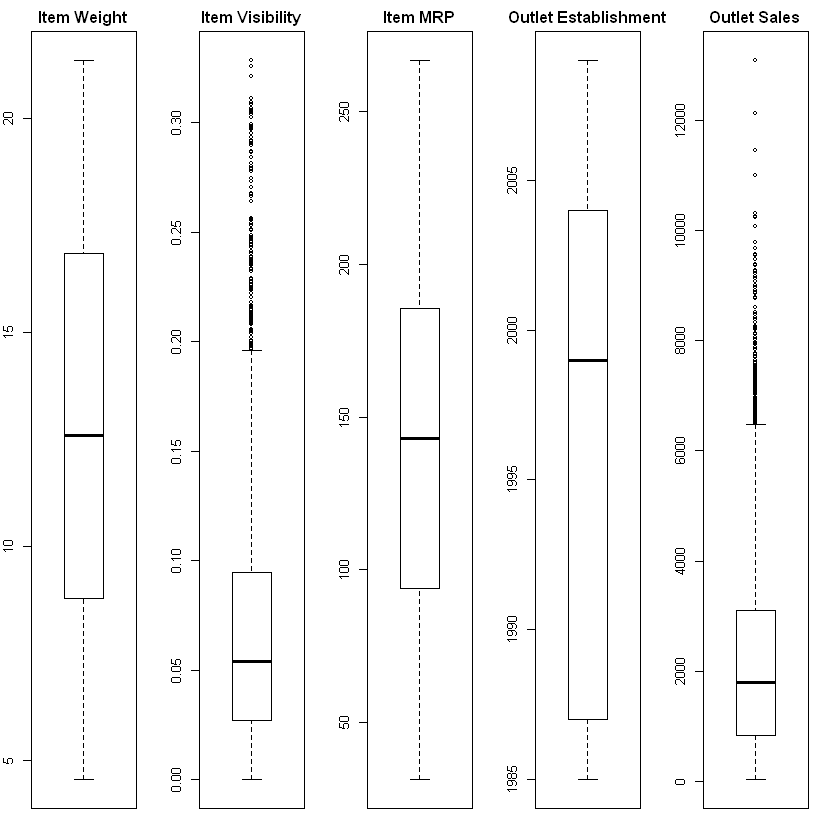

In [14]:
par(mfrow=c(1,5), mar=c(2,2,2,2))
boxplot(df$Item_Weight,main='Item Weight')
boxplot(df$Item_Visibility,main='Item Visibility')
boxplot(df$Item_MRP,main='Item MRP')
boxplot(df$Outlet_Establishment_Year,main='Outlet Establishment')
boxplot(df$Item_Outlet_Sales,main='Outlet Sales')

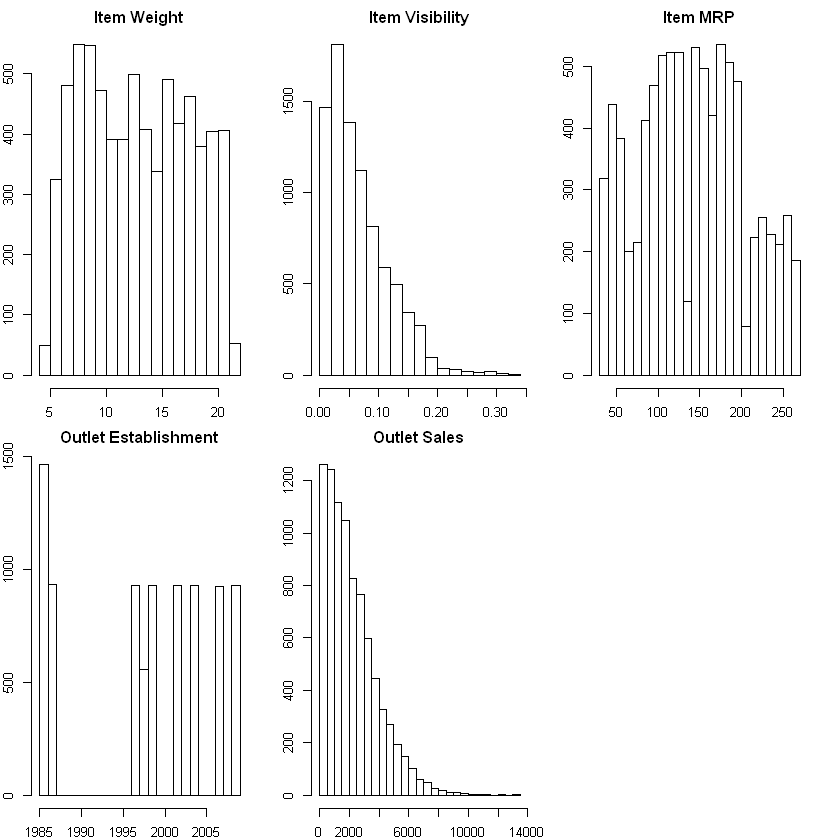

In [15]:
par(mfrow=c(2,3), mar=c(2,2,2,2))
hist(df$Item_Weight,main='Item Weight',breaks=20)
hist(df$Item_Visibility,main='Item Visibility',breaks=20)
hist(df$Item_MRP,main='Item MRP',breaks=20)
hist(df$Outlet_Establishment_Year,main='Outlet Establishment',breaks=20)
hist(df$Item_Outlet_Sales,main='Outlet Sales',breaks=20)

The two variables with extreme values are item visibility and outlet sales. However, the extreme values are numerous and are consistent with the skewed distributions observed in the histogram. Therefore they are not considered outliers.

Next, check for correlations.

In [16]:
cor(df[,c(1,3,5,7,14)],use='complete.obs')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,ItemNumber
Item_Weight,1.00000000,-0.014047726,0.027141154,-0.011588290,0.025286621
Item_Visibility,-0.01404773,1.000000000,-0.006061148,-0.016935201,-0.026579321
Item_MRP,0.02714115,-0.006061148,1.000000000,-0.001656520,-0.018875820
Outlet_Establishment_Year,-0.01158829,-0.016935201,-0.001656520,1.000000000,0.001171761
ItemNumber,0.02528662,-0.026579321,-0.018875820,0.001171761,1.000000000


In [17]:
chisqfun <- function(a,b){
    if(a==b) return(0)
    else return(round(chisq.test(table(df[,a],df[,b]))$p.value,2))
}
matrix(mapply(chisqfun,rep(c(2,4,6,8:10,12:13),8),rep(c(2,4,6,8:10,12:13),rep(8,8))),8,8,dimnames=list(names(df[c(2,4,6,8:10,12:13)]),names(df[c(2,4,6,8:10,12:13)])))

Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"Warning message in chisq.test(table(df[, a], df[, b])):
"Chi-squared approximation may be incorrect"

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,ItemPrefix2,ItemPrefix3
Item_Fat_Content,0.00,0,1,0.91,0.94,0.99,0.00,0
Item_Type,0.00,0,1,1.00,1.00,1.00,0.00,0
Outlet_Identifier,1.00,1,0,NaN,0.00,0.00,1.00,1
Outlet_Size,0.91,1,NaN,0.00,0.00,0.00,0.96,1
Outlet_Location_Type,0.94,1,0,0.00,0.00,0.00,0.90,1
Outlet_Type,0.99,1,0,0.00,0.00,0.00,0.90,1
ItemPrefix2,0.00,0,1,0.96,0.90,0.90,0.00,0
ItemPrefix3,0.00,0,1,1.00,1.00,1.00,0.00,0


Some of the factors are not independent. The strength of correlation will be evaluated after dummy coding.

Next, factors will be coded and pre-processing will be performed.

In [18]:
X <- predict(dummyVars(Item_Outlet_Sales~.,df,fullRank=TRUE),df)
dimnames(X)[[2]] <- gsub(' ','',dimnames(X)[[2]])
head(X,5)

,Item_Weight,Item_Fat_Content.reg,Item_Visibility,Item_Type.Breads,Item_Type.Breakfast,Item_Type.Canned,Item_Type.Dairy,Item_Type.FrozenFoods,Item_Type.FruitsandVegetables,Item_Type.HardDrinks,...,ItemPrefix3.NCR,ItemPrefix3.NCS,ItemPrefix3.NCT,ItemPrefix3.NCU,ItemPrefix3.NCV,ItemPrefix3.NCW,ItemPrefix3.NCX,ItemPrefix3.NCY,ItemPrefix3.NCZ,ItemNumber
1,9.30,0,0.01604730,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,5.92,1,0.01927822,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,17.50,0,0.01676007,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,19.20,1,0.00000000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
5,8.93,0,0.00000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19


In [19]:
preprocessparams <- preProcess(X,method=c('center','scale','bagImpute'))
processedX <- predict(preprocessparams, X)
head(processedX,5)

,Item_Weight,Item_Fat_Content.reg,Item_Visibility,Item_Type.Breads,Item_Type.Breakfast,Item_Type.Canned,Item_Type.Dairy,Item_Type.FrozenFoods,Item_Type.FruitsandVegetables,Item_Type.HardDrinks,...,ItemPrefix3.NCR,ItemPrefix3.NCS,ItemPrefix3.NCT,ItemPrefix3.NCU,ItemPrefix3.NCV,ItemPrefix3.NCW,ItemPrefix3.NCX,ItemPrefix3.NCY,ItemPrefix3.NCZ,ItemNumber
1,-0.7661631,-0.7381039,-0.9706752,-0.1741831,-0.1143393,-0.2870775,3.3905337,-0.3341171,-0.4110421,-0.1604749,...,-0.08628983,-0.08348582,-0.07446085,-0.0768141,-0.07834456,-0.07285076,-0.08348582,-0.0813212,-0.0813212,-0.8888121
2,-1.4940692,1.3546638,-0.9080580,-0.1741831,-0.1143393,-0.2870775,-0.2949042,-0.3341171,-0.4110421,-0.1604749,...,-0.08628983,-0.08348582,-0.07446085,-0.0768141,-0.07834456,-0.07285076,-0.08348582,-0.0813212,-0.0813212,-1.7006530
3,0.9997627,-0.7381039,-0.9568612,-0.1741831,-0.1143393,-0.2870775,-0.2949042,-0.3341171,-0.4110421,-0.1604749,...,-0.08628983,-0.08348582,-0.07446085,-0.0768141,-0.07834456,-0.07285076,-0.08348582,-0.0813212,-0.0813212,-0.8888121
4,1.3658693,1.3546638,-1.2816826,-0.1741831,-0.1143393,-0.2870775,-0.2949042,-0.3341171,2.4325553,-0.1604749,...,-0.08628983,-0.08348582,-0.07446085,-0.0768141,-0.07834456,-0.07285076,-0.08348582,-0.0813212,-0.0813212,-1.3527212
5,-0.8458452,-0.7381039,-1.2816826,-0.1741831,-0.1143393,-0.2870775,-0.2949042,-0.3341171,-0.4110421,-0.1604749,...,-0.08628983,-0.08348582,-0.07446085,-0.0768141,-0.07834456,-0.07285076,-0.08348582,-0.0813212,-0.0813212,-0.6568575


Check for  and remove any correlated dummy variables

In [20]:
cormatrix <-cor(X,use='complete.obs')
cormatrix[is.na(cormatrix)] <- 0
findCorrelation(cormatrix,0.9,names=TRUE, exact=FALSE)
findCorrelation(cormatrix,0.9, exact=FALSE)

Warning message in cor(X, use = "complete.obs"):
"the standard deviation is zero"

[1] "Outlet_Identifier.OUT035"     "Outlet_Identifier.OUT018"    
[3] "Outlet_Type.SupermarketType1"

[1] 25 22 34

In [21]:
processedX <- processedX[,-c(25,22,34)]

## Data Visualization

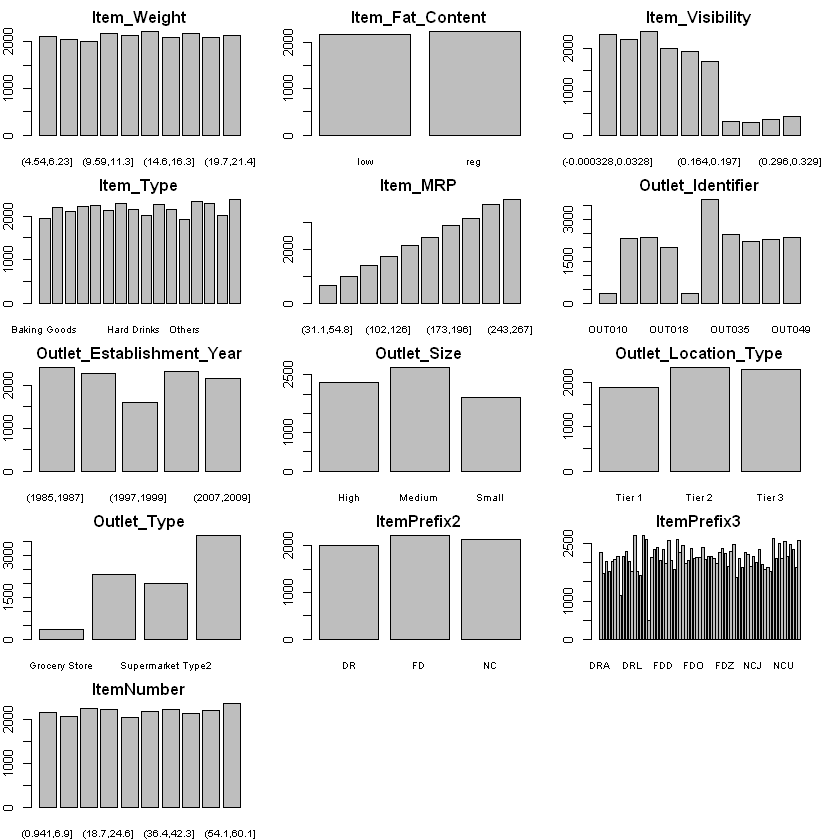

In [22]:
par(mfrow=c(5,3),mar=c(2,2,2,2))
for(i in 1:14){
    if(i %in% c(2,4,6,8:10,12:13)) heightmatrix <- as.matrix(aggregate(df[,11],list(df[,i]),mean))
    else if(i != 11) heightmatrix <- as.matrix(aggregate(df[,11],list(cut(df[,i],10)),mean))
    if(i!=11){
        heights <- as.numeric(heightmatrix[,2])
        names(heights) <- heightmatrix[,1]
        barplot(heights, beside=TRUE, main=names(df)[i],cex.names=0.75)
    }
}

Item visibility, MRP, outlet indentifier, and outlet type seem to have the largest effects on sales.

## Linear Model

First model with all the current features.

In [23]:
linearmod <-lm(df[,11]~processedX)
lmsummary <- summary(linearmod)
lmsummary


Call:
lm(formula = df[, 11] ~ processedX)

Residuals:
    Min      1Q  Median      3Q     Max 
-4372.4  -682.0   -87.0   571.3  7880.6 

Coefficients: (8 not defined because of singularities)
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                             2283.7186    12.9386 176.505  < 2e-16
processedXItem_Weight                     -2.3546    13.8642  -0.170   0.8651
processedXItem_Fat_Content.reg            24.2491    13.8339   1.753   0.0797
processedXItem_Visibility                -15.8401    13.0961  -1.210   0.2265
processedXItem_Type.Breads                 0.1974    14.4324   0.014   0.9891
processedXItem_Type.Breakfast              9.1583    13.5397   0.676   0.4988
processedXItem_Type.Canned                14.2974    16.8406   0.849   0.3959
processedXItem_Type.Dairy                -11.7418    18.2689  -0.643   0.5204
processedXItem_Type.FrozenFoods           -2.3343    17.9588  -0.130   0.8966
processedXItem_Type.Fruitsa

Significance of features is summarized below.

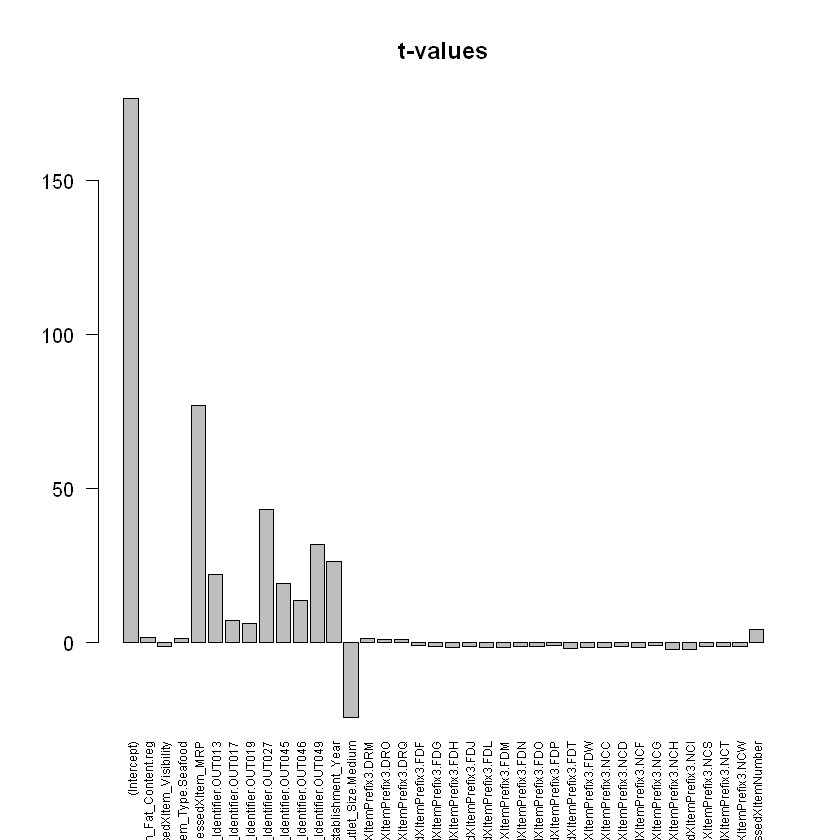

In [24]:
barplot(lmsummary$coefficients[abs(lmsummary$coefficients[,3])>=1,3],main='t-values',cex.names=0.6,las=2)

In [25]:
sigfeatures <- lmsummary$coefficients[abs(lmsummary$coefficients[,4])<=0.05,]
sigfeatures

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2283.71861,12.93858,176.504568,0.000000e+00
processedXItem_MRP,970.89650,12.63025,76.870748,0.000000e+00
processedXOutlet_Identifier.OUT013,750.78317,33.93937,22.121307,1.900360e-105
processedXOutlet_Identifier.OUT017,102.15748,14.27344,7.157173,8.926718e-13
processedXOutlet_Identifier.OUT019,188.08163,29.37974,6.401745,1.618243e-10
processedXOutlet_Identifier.OUT027,1649.66946,38.07139,43.330953,0.000000e+00
processedXOutlet_Identifier.OUT045,278.83950,14.50041,19.229768,1.099017e-80
processedXOutlet_Identifier.OUT046,278.17601,20.44095,13.608759,9.792648e-42
processedXOutlet_Identifier.OUT049,578.17295,18.15598,31.844759,3.124907e-210
processedXOutlet_Establishment_Year,1239.59742,46.90286,26.429038,6.045229e-148


Add interactions of significant features to design matrix.

In [28]:
sigfeaturelist <- str_replace_all(dimnames(sigfeatures)[[1]],'processedX','')[-1]
sigfeaturelist 

[1] "Item_MRP"                  "Outlet_Identifier.OUT013" 
 [3] "Outlet_Identifier.OUT017"  "Outlet_Identifier.OUT019" 
 [5] "Outlet_Identifier.OUT027"  "Outlet_Identifier.OUT045" 
 [7] "Outlet_Identifier.OUT046"  "Outlet_Identifier.OUT049" 
 [9] "Outlet_Establishment_Year" "Outlet_Size.Medium"       
[11] "ItemPrefix3.NCH"           "ItemPrefix3.NCI"          
[13] "ItemNumber"

In [29]:
InterX <- as.data.frame(processedX)
for(a in 1:12){
    for(b in (a+1):13){
        intername <- paste(sigfeaturelist[a],sigfeaturelist[b],sep='x')
        InterX <- mutate(InterX,!!intername := processedX[,sigfeaturelist[a]]*processedX[,sigfeaturelist[b]])
    }
}
InterX <- as.matrix(InterX)

Check for and remove interactions that are highly correlated with other features.

In [30]:
intercormatrix <-cor(InterX,use='complete.obs')
intercormatrix[is.na(cormatrix)] <- 0
diag(intercormatrix) <- 0
maxcor <- apply(intercormatrix,1,max)
filteredindex <- 1:length(maxcor)
filteredindex <- filteredindex[(maxcor >= 0.9)&(filteredindex>98)]
filteredindex

[1] 125 126 135 144 145 153 165 170 171

In [31]:
InterX <-InterX[,-filteredindex]

Run linear model with interactions.

In [32]:
linearmodinter <-lm(df[,11]~InterX)
lmintersummary <- summary(linearmodinter)
lmintersummary


Call:
lm(formula = df[, 11] ~ InterX)

Residuals:
    Min      1Q  Median      3Q     Max 
-5514.8  -534.7   -53.6   452.4  6873.6 

Coefficients: (36 not defined because of singularities)
                                                           Estimate Std. Error
(Intercept)                                              2284.92041   12.28974
InterXItem_Weight                                          -6.06602   13.16625
InterXItem_Fat_Content.reg                                 17.44366   13.12486
InterXItem_Visibility                                     -13.72552   12.43355
InterXItem_Type.Breads                                      1.64473   13.68194
InterXItem_Type.Breakfast                                   8.65375   12.83275
InterXItem_Type.Canned                                     10.90327   15.97262
InterXItem_Type.Dairy                                      -9.23726   17.32069
InterXItem_Type.FrozenFoods                                -6.18434   17.02545
InterXItem_Type.Frui

Filter out insignificant features.

In [33]:
siginter <-lmintersummary$coefficients[lmintersummary$coefficients[,4]<=0.05,]
siginterlist <- str_replace_all(dimnames(siginter)[[1]],'InterX','')[-1]
siginterlist <- siginterlist[13:25]
siginterlist

[1] "Item_MRPxOutlet_Identifier.OUT013"       
 [2] "Item_MRPxOutlet_Identifier.OUT017"       
 [3] "Item_MRPxOutlet_Identifier.OUT019"       
 [4] "Item_MRPxOutlet_Identifier.OUT027"       
 [5] "Item_MRPxOutlet_Identifier.OUT045"       
 [6] "Item_MRPxOutlet_Identifier.OUT046"       
 [7] "Item_MRPxOutlet_Identifier.OUT049"       
 [8] "Item_MRPxOutlet_Establishment_Year"      
 [9] "Item_MRPxOutlet_Size.Medium"             
[10] "Item_MRPxItemPrefix3.NCH"                
[11] "Item_MRPxItemPrefix3.NCI"                
[12] "Item_MRPxItemNumber"                     
[13] "Outlet_Identifier.OUT013xItemPrefix3.NCH"

In [34]:
fullX <- as.data.frame(processedX)
for(a in siginterlist){
        fullX <- mutate(fullX,!!a := InterX[,a])
}
fullX <- as.matrix(fullX)

linearmodfull <-lm(df[,11]~fullX)
lmfullsummary <- summary(linearmodfull)
lmfullsummary


Call:
lm(formula = df[, 11] ~ fullX)

Residuals:
    Min      1Q  Median      3Q     Max 
-5548.3  -539.1   -51.3   455.9  6917.1 

Coefficients: (8 not defined because of singularities)
                                               Estimate Std. Error t value
(Intercept)                                   2285.3341    12.2749 186.179
fullXItem_Weight                                -6.3010    13.1433  -0.479
fullXItem_Fat_Content.reg                       17.2192    13.1198   1.312
fullXItem_Visibility                           -12.4791    12.4140  -1.005
fullXItem_Type.Breads                            1.6217    13.6760   0.119
fullXItem_Type.Breakfast                         8.9046    12.8283   0.694
fullXItem_Type.Canned                           11.1434    15.9631   0.698
fullXItem_Type.Dairy                            -9.5597    17.3132  -0.552
fullXItem_Type.FrozenFoods                      -6.6393    17.0187  -0.390
fullXItem_Type.FruitsandVegetables               8.6987    18.

Add square and cube features for continuous features.

In [35]:
nonlinX <- as.data.frame(fullX)
continuouslist <- c('Item_Weight','Item_MRP','Item_Visibility','Outlet_Establishment_Year')
for(a in continuouslist){
    sqname <- paste(a,'sqr',sep='.')
    cubname <- paste(a,'cub',sep='.')
    nonlinX <- mutate(nonlinX,!!sqname := fullX[,a]^2)
    nonlinX <- mutate(nonlinX,!!cubname := fullX[,a]^3)
}
nonlinX <- as.matrix(nonlinX)

nonlinearmod <-lm(df[,11]~nonlinX)
nlmsummary <- summary(nonlinearmod)
nlmsummary


Call:
lm(formula = df[, 11] ~ nonlinX)

Residuals:
    Min      1Q  Median      3Q     Max 
-5451.3  -533.3   -50.9   456.1  6908.8 

Coefficients: (10 not defined because of singularities)
                                                  Estimate Std. Error t value
(Intercept)                                     2309.78682   24.45734  94.441
nonlinXItem_Weight                                47.52413   32.04466   1.483
nonlinXItem_Fat_Content.reg                       16.73881   13.12263   1.276
nonlinXItem_Visibility                           -19.48536   15.44958  -1.261
nonlinXItem_Type.Breads                            0.34177   13.68739   0.025
nonlinXItem_Type.Breakfast                         8.97961   12.85298   0.699
nonlinXItem_Type.Canned                           10.17210   15.97353   0.637
nonlinXItem_Type.Dairy                            -8.72684   17.34316  -0.503
nonlinXItem_Type.FrozenFoods                      -7.47347   17.04192  -0.439
nonlinXItem_Type.FruitsandVeg

Only the cube of item weight and MRP is significant (at alpha = 0.1), so other cube and square terms are removed.

In [36]:
finalX <- as.data.frame(fullX)
continuouslist <- c('Item_Weight','Item_MRP')
for(a in continuouslist){
    cubname <- paste(a,'cub',sep='.')
    finalX <- mutate(finalX,!!cubname := fullX[,a]^3)
}
finalX <- as.matrix(finalX)
finallinearmod <-lm(df[,11]~finalX)
finallmsummary <- summary(finallinearmod)
finallmsummary


Call:
lm(formula = df[, 11] ~ finalX)

Residuals:
    Min      1Q  Median      3Q     Max 
-5459.4  -531.9   -53.0   452.7  6914.5 

Coefficients: (8 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                    2290.3463    12.3960 184.765
finalXItem_Weight                                52.2886    31.8723   1.641
finalXItem_Fat_Content.reg                       16.4154    13.1180   1.251
finalXItem_Visibility                           -13.3536    12.4133  -1.076
finalXItem_Type.Breads                            0.3820    13.6849   0.028
finalXItem_Type.Breakfast                         8.8011    12.8506   0.685
finalXItem_Type.Canned                           10.5802    15.9649   0.663
finalXItem_Type.Dairy                            -8.8606    17.3183  -0.512
finalXItem_Type.FrozenFoods                      -7.2372    17.0190  -0.425
finalXItem_Type.FruitsandVegetables               7

The singularities are caused by features that are linear combinations of other features. These are filtered out by taking only features listed in the linear model coefficient summary.

In [46]:
finalfeaturelist <- str_replace_all(dimnames(finallmsummary$coefficients)[[1]],'finalX','')[-1]
finalX <- finalX[,finalfeaturelist]
finallinearmod <-lm(df[,11]~finalX)
finallmsummary <- summary(finallinearmod)
finallmsummary


Call:
lm(formula = df[, 11] ~ finalX)

Residuals:
    Min      1Q  Median      3Q     Max 
-5459.4  -531.9   -53.0   452.7  6914.5 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                    2290.3463    12.3960 184.765
finalXItem_Weight                                52.2886    31.8723   1.641
finalXItem_Fat_Content.reg                       16.4154    13.1180   1.251
finalXItem_Visibility                           -13.3536    12.4133  -1.076
finalXItem_Type.Breads                            0.3820    13.6849   0.028
finalXItem_Type.Breakfast                         8.8011    12.8506   0.685
finalXItem_Type.Canned                           10.5802    15.9649   0.663
finalXItem_Type.Dairy                            -8.8606    17.3183  -0.512
finalXItem_Type.FrozenFoods                      -7.2372    17.0190  -0.425
finalXItem_Type.FruitsandVegetables               7.2100    18.4500   0.391
finalXItem_Type.

Check for normality of residuals


	Shapiro-Wilk normality test

data:  sample(finallmsummary$residuals, 5000)
W = 0.95835, p-value < 2.2e-16


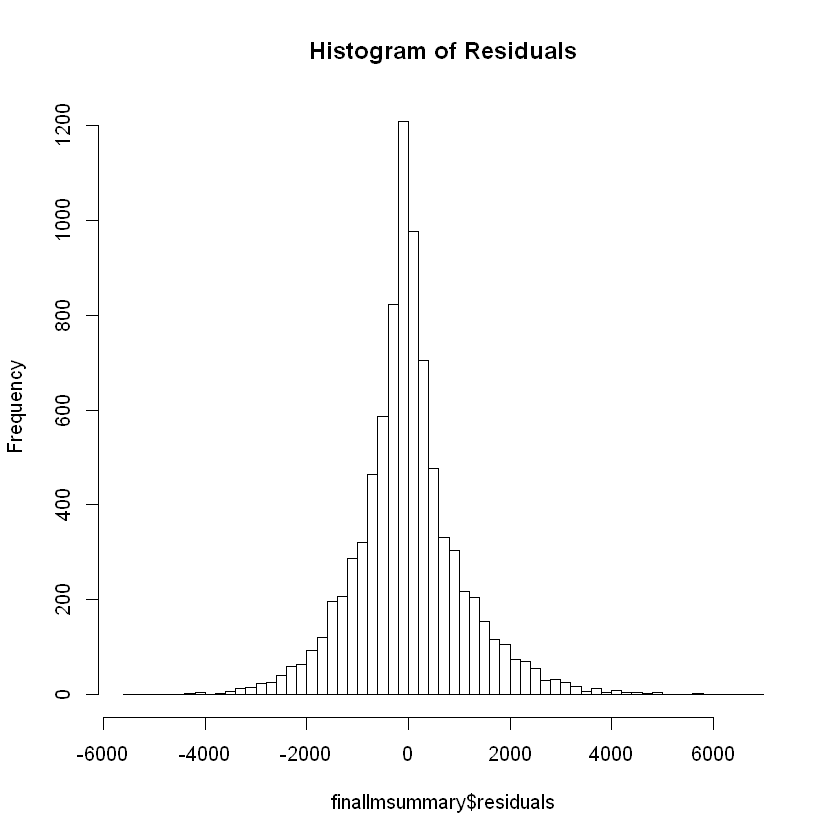

In [47]:
hist(finallmsummary$residuals,50, main='Histogram of Residuals')
shapiro.test(sample(finallmsummary$residuals,5000))

The residual distribution has heavy tails, possibly indicating a large influence of features not captured in the model or in the data set.

The significance of features in the model is summarized below.

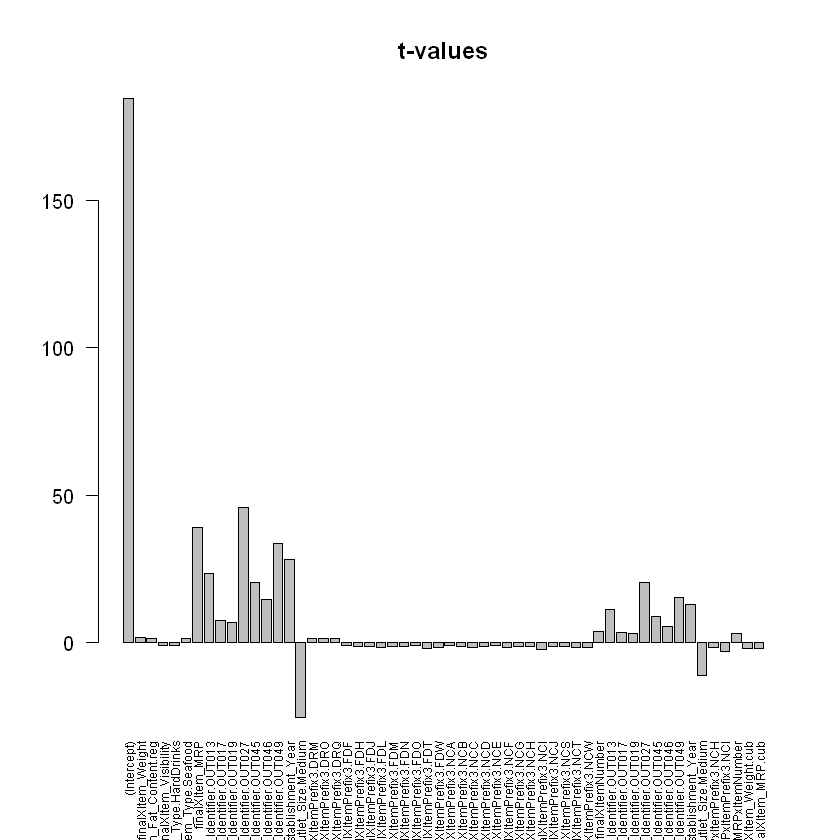

In [48]:
barplot(finallmsummary$coefficients[abs(finallmsummary$coefficients[,3])>=1,3],main='t-values',cex.names=0.6,las=2)

In [49]:
finallmsummary$coefficients[finallmsummary$coefficients[,4]<=0.1,]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2290.34625,12.39601,184.764729,0.000000e+00
finalXItem_MRP,1066.70848,27.22300,39.184090,1.302347e-308
finalXOutlet_Identifier.OUT013,757.53434,32.14573,23.565630,5.852413e-119
finalXOutlet_Identifier.OUT017,102.78752,13.51861,7.603411,3.194981e-14
finalXOutlet_Identifier.OUT019,188.75018,27.82621,6.783181,1.255057e-11
finalXOutlet_Identifier.OUT027,1657.92788,36.05383,45.984797,0.000000e+00
finalXOutlet_Identifier.OUT045,280.17338,13.73227,20.402561,2.382812e-90
finalXOutlet_Identifier.OUT046,282.81046,19.36473,14.604412,1.007887e-47
finalXOutlet_Identifier.OUT049,580.33109,17.19359,33.752763,2.506709e-234
finalXOutlet_Establishment_Year,1247.30512,44.41542,28.082702,6.066573e-166


Cross validation is performed to check for overfitting.

In [51]:
fulllinearmodel <- train(finalX,df[,11],method='lm',trControl=trainControl(method='repeatedcv',number=5,repeats=3))
fulllinearmodel

Linear Regression 

8523 samples
 113 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 6819, 6817, 6819, 6819, 6818, 6819, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1077.878  0.6014958  759.3767

Tuning parameter 'intercept' was held constant at a value of TRUE

The RMSE is comparable to that of the model fit to the entire data set, indicating overfitting is minimal. Therefore the model will not be reduced further, nor will any regularization penalties be added.

## Decision Tree 

In [64]:
Grid <- expand.grid(cp=c(0.0005,0.001,0.002,0.003,0.004,0.005))
treemodel <- train(processedX,df[,11],method='rpart',trControl=trainControl(method='repeatedcv',number=5,repeats=3),tuneGrid=Grid)
treemodel

CART 

8523 samples
 106 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 6817, 6818, 6819, 6820, 6818, 6818, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared   MAE     
  5e-04  1148.888  0.5520473  793.2892
  1e-03  1105.266  0.5813093  773.1895
  2e-03  1098.391  0.5859018  782.0021
  3e-03  1101.527  0.5835262  785.5887
  4e-03  1102.768  0.5825808  786.9578
  5e-03  1106.873  0.5794607  790.0889

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.002.

In [69]:
Grid <- expand.grid(cp=c(0.0016,0.0017,0.0018,0.0019,0.002))
treemodel <- train(processedX,df[,11],method='rpart',trControl=trainControl(method='repeatedcv',number=5,repeats=3),tuneGrid=Grid)
treemodel

CART 

8523 samples
 106 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 6818, 6818, 6818, 6819, 6819, 6817, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared   MAE     
  0.0016  1097.356  0.5868223  779.9323
  0.0017  1097.245  0.5868887  780.0096
  0.0018  1097.269  0.5868148  780.4726
  0.0019  1097.308  0.5867609  780.5750
  0.0020  1098.377  0.5859599  781.1463

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.0017.

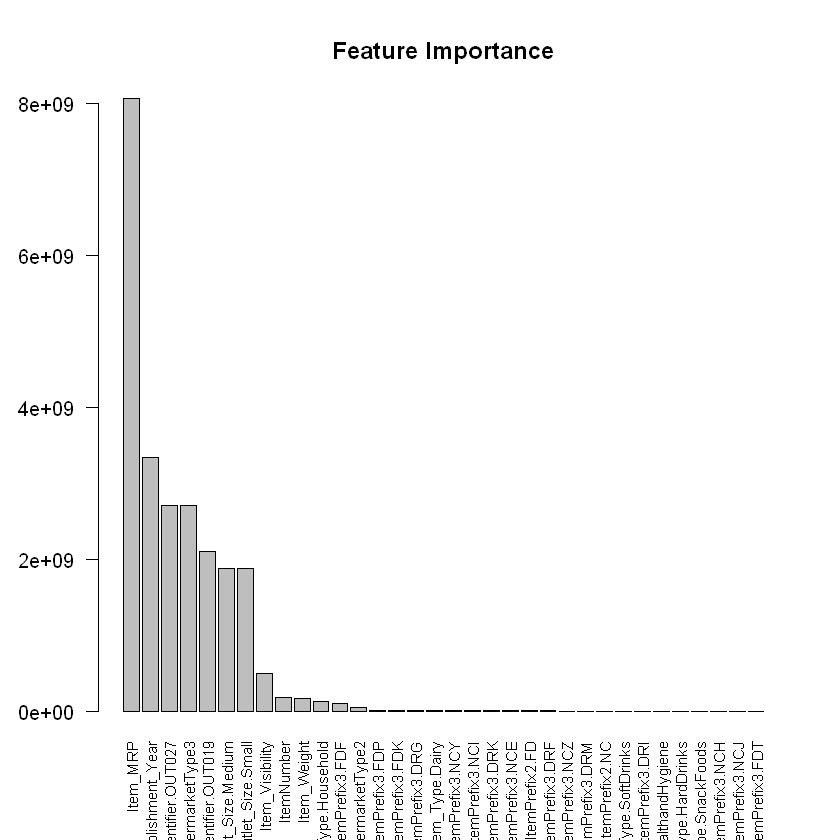

In [76]:
barplot(treemodel$finalModel$variable.importance,main='Feature Importance',cex.names=0.75,las=2)

## Model Selection

The linear model is slightly better than the decision tree model in terms of cros validation RMSE, therefore the linear model will be selected as the final model.

The test data set is processed the same way as the training set.

In [89]:
test <- read.csv('C:/Datasets/SalesTest.txt',na.strings='')
test$Item_Outlet_Sales <- 0
test$ItemPrefix2 <- factor(substring(test[,1],1,2))
test$ItemPrefix3 <- factor(substring(test[,1],1,3))
test$ItemNumber <- as.numeric(substring(test[,1],4,5))
itemID <- test[,1]
test<-test[,-1]
test$Item_Fat_Content <- factor(ifelse(test$Item_Fat_Content %in% c('reg','Regular'), 'reg','low'))
testX <- predict(dummyVars(Item_Outlet_Sales~.,df,fullRank=TRUE),test)
dimnames(testX)[[2]] <- gsub(' ','',dimnames(testX)[[2]])
processedtestX <- predict(preprocessparams, testX)
processedtestX <- processedtestX[,-c(25,22,34)]
IntertestX <- as.data.frame(processedtestX)

for(a in 1:12){
    for(b in (a+1):13){
        intername <- paste(sigfeaturelist[a],sigfeaturelist[b],sep='x')
        IntertestX <- mutate(IntertestX,!!intername := processedtestX[,sigfeaturelist[a]]*processedtestX[,sigfeaturelist[b]])
    }
}
IntertestX <- as.matrix(IntertestX)
fulltestX <- as.data.frame(processedtestX)

for(a in siginterlist){
        fulltestX <- mutate(fulltestX,!!a := IntertestX[,a])
}
fulltestX <- as.matrix(fulltestX)

finaltestX <- as.data.frame(fulltestX)
for(a in continuouslist){
    cubname <- paste(a,'cub',sep='.')
    finaltestX <- mutate(finaltestX,!!cubname := fulltestX[,a]^3)
}
finaltestX <- as.matrix(finaltestX)
finaltestX <- finaltestX[,finalfeaturelist]

Then the model is used to predict sales for the test set.

In [90]:
results <- predict(fulllinearmodel,finaltestX)

In [94]:
resulttable <- as.data.frame(itemID)
resulttable$Outlet_Identifier <- test$Outlet_Identifier
resulttable$Item_Outlet_Sales <- results
write.csv(resulttable,'C:/Datasets/SalesTestPredict.csv')